### Knowledge Graph

also introducing new packages 
- **RAKE**: Rapid Automatic Keyword Extraction algorithm using NLTK
- pyLDAvis : Python library for interactive topic model visualization

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import numpy as np 
import pandas as pd 
import glob
import json

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

root_path = '../corona_research_challenge_data/2020-03-13/'
metadata_path = f'{root_path}/all_sources_metadata_2020-03-13.csv'
# Pathe to all json files
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)

In [13]:
df = pd.read_csv(root_path + "metadata.csv")

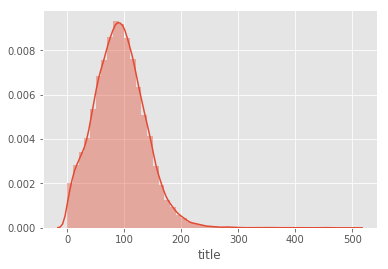

In [19]:
sns.distplot(df['title'].str.len().fillna(0))

In [27]:
stop=set(stopwords.words('english'))

def build_list(df,col="title"):
    corpus=[]
    lem=WordNetLemmatizer()
    stop=set(stopwords.words('english'))
    new= df[col].dropna().str.split()
    new=new.values.tolist()
    corpus=[lem.lemmatize(word.lower()) for i in new for word in i if(word) not in stop]
    
    return corpus

In [30]:
corpus = build_list(df=df)

### Which are the most common bi-grams in title?

In [36]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

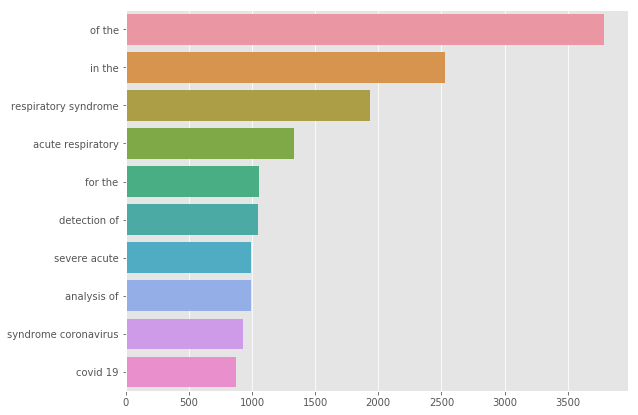

In [37]:
top_n_bigrams=get_top_ngram(all_sources['title'].dropna(),2)[:10]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

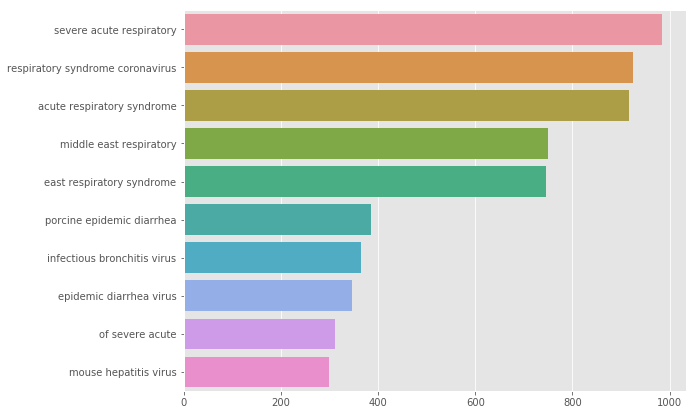

In [38]:
top_tri_grams=get_top_ngram(all_sources['title'].dropna(),n=3)
x,y=map(list,zip(*top_tri_grams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### Topic Modeling

**Each document can be described by a distribution of topics and each topic can be described by a distribution of words**

https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158

In [39]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['title'].dropna()[:5000]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [42]:
corpus=preprocess_news(df)
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [43]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)

In [46]:
import pyLDAvis.gensim

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/home/dmeijerink/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063178  0.156821       1        1  34.927834
0     -0.196846 -0.015684       2        1  26.531776
2      0.104034 -0.118447       3        1  19.568169
3      0.029634 -0.022690       4        1  18.972223, topic_info=     Category        Freq         Term       Total  loglift  logprob
4899  Default  777.000000      Chapter  777.000000  30.0000  30.0000
417   Default  225.000000        Index  225.000000  29.0000  29.0000
2421  Default  143.000000     Diseases  143.000000  28.0000  28.0000
31    Default   88.000000  respiratory   88.000000  27.0000  27.0000
1769  Default   71.000000     syndrome   71.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
633    Topic4   15.296869   infectious   43.019131   0.6282  -5.9638
3199   Topic4   15.642466      Disease   80.756676   0.0207  -5.9414
6810   Topic4   15.272028     SARS-CoV   69.955490   0.1404  -5.9654
269    Topic4   15.948527  coronavirus  210.580887  -0.9183  -5.9220
4899   Topic4   15.040715      Chapter  777.807922  -2.2835  -5.9807

[265 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
5006      2  0.898257                   2004
7810      3  0.986272            Abkürzungen
7794      1  0.918891  Abkürzungsverzeichnis
7973      3  0.881333               Académie
46        1  0.016224                  Acute
...     ...       ...                    ...
5         2  0.025130                  virus
5         3  0.163347                  virus
5         4  0.229314                  virus
365       1  0.495313                 volume
365       4  0.495313                 volume

[392 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])